In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, auc, roc_curve

In [4]:
df = pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


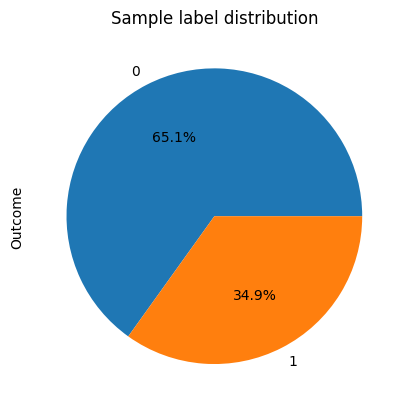

In [6]:
df['Outcome'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title("Sample label distribution")
plt.show()

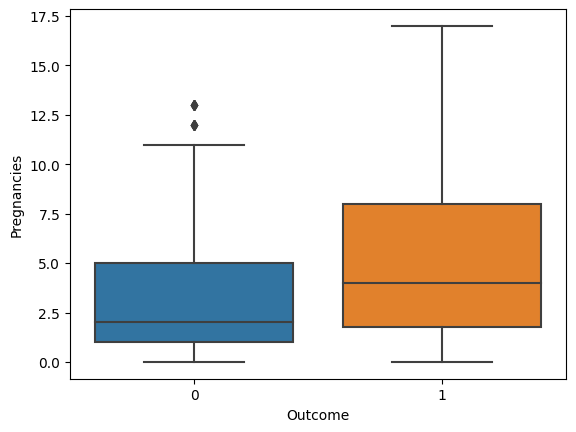

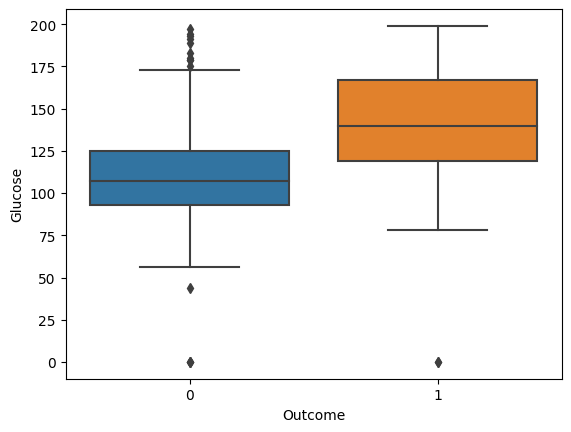

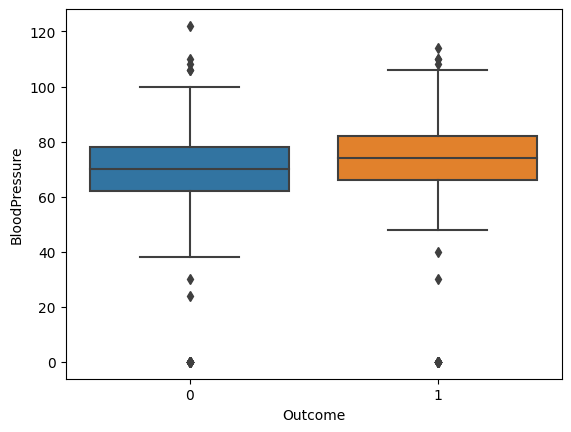

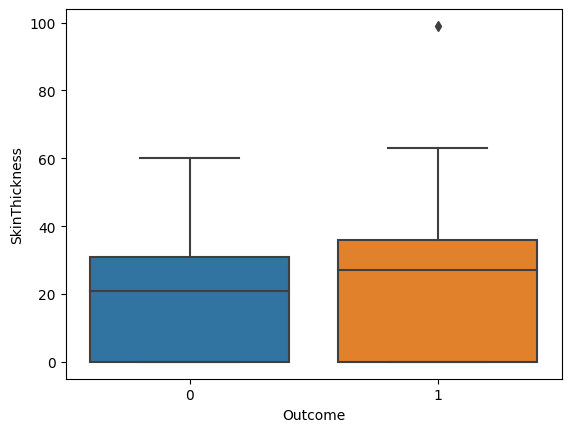

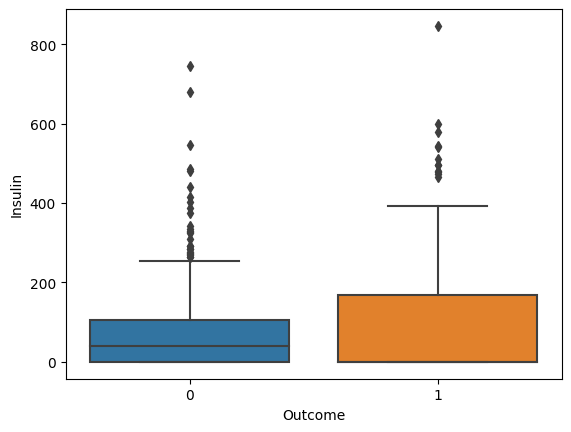

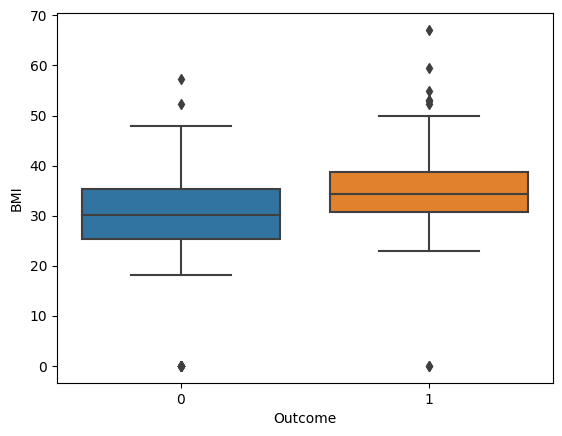

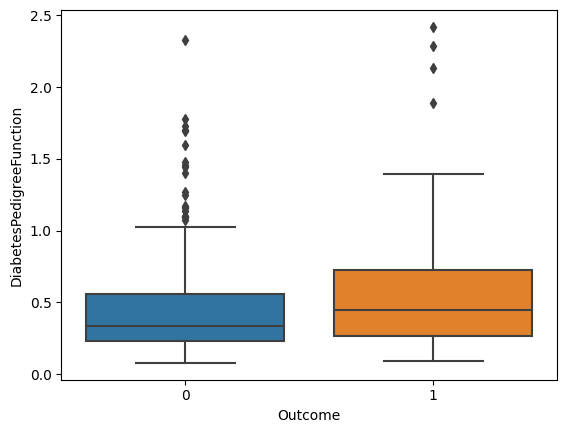

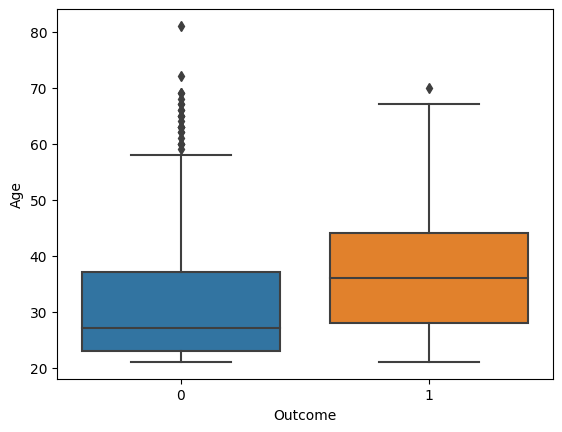

In [7]:
for col in df.columns[:-1]:
    sns.boxplot(x = 'Outcome', y = col, data = df)
    plt.show()
    

In [8]:
test_result = []
mask = df['Outcome'] == 1
for col in df.columns[:-1]:
    arr0 = df[col][~mask]
    arr1 = df[col][mask]
    res = ttest_ind(arr1, arr0)
    mean0 = arr0.mean()
    mean1 = arr1.mean()
    test_result.append([col, mean0, mean1, res.statistic, res.pvalue])
tTest_df = pd.DataFrame(test_result, 
                        columns = ['feature', 'Group0', 'Group1', 'T-statistic','p-value'])
tTest_df.sort_values("p-value")

,feature,Group0,Group1,T-statistic,p-value
1,Glucose,109.980000,141.257463,14.600060,8.935432e-43
5,BMI,30.304200,35.142537,8.471840,1.229807e-16
7,Age,31.190000,37.067164,6.792688,2.209975e-11
0,Pregnancies,3.298000,4.865672,6.298431,5.065127e-10
6,DiabetesPedigreeFunction,0.429734,0.550500,4.885826,1.254607e-06
4,Insulin,68.792000,100.335821,3.644325,2.861865e-04
3,SkinThickness,19.664000,22.164179,2.074700,3.834770e-02
2,BloodPressure,68.184000,70.824627,1.804702,7.151390e-02


In [9]:
X = df.drop(['BloodPressure',"Outcome"], axis = 1) 
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X,y ,train_size=0.8, random_state=11)

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scalered = scaler.transform(X_train)
X_test_scalered = scaler.transform(X_test)

In [109]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SimpleMLP, self).__init__()
        
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, 1) 
        
        self.activation = nn.ReLU()
#         self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.activation(self.hidden(x))
        return self.activation(self.output(x))

In [13]:
X_train_tensor = torch.tensor(X_train_scalered, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1) #使其成为列向量

X_test_tensor = torch.tensor(X_test_scalered, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)  #使其成为列向量


In [118]:
torch.manual_seed(3)

model = SimpleMLP(input_dim=X.shape[1], hidden_dim=128)  

criterion = nn.BCELoss()

optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_history = []
num_epochs = 500 
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss_history.append(loss.item())
    loss.backward()
    optimizer.step()

In [119]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_class = (y_pred > 0.5).float()
    accuracy = (y_pred_class == y_test_tensor).float().mean()
    print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7273


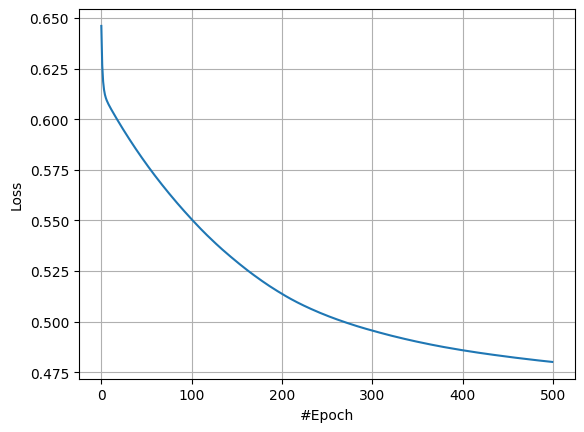

In [120]:
plt.plot(loss_history)
plt.xlabel("#Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

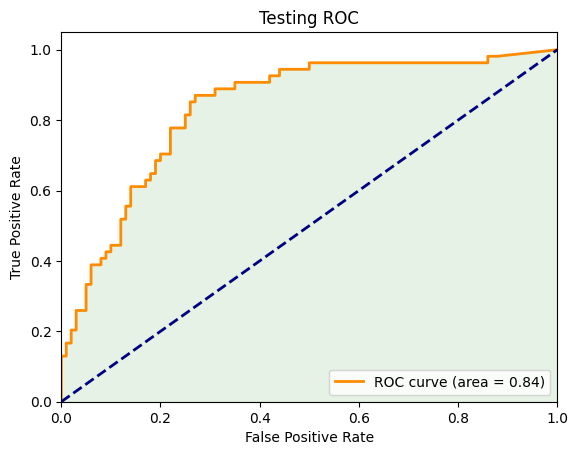

In [121]:
fpr,tpr,threshold = roc_curve(y_test, y_pred)
test_auc = auc(fpr,tpr)

plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % test_auc) 
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.fill_between(fpr, tpr, where=(tpr>0), color='green', alpha=0.1)
plt.title('Testing ROC')
plt.legend(loc="lower right")

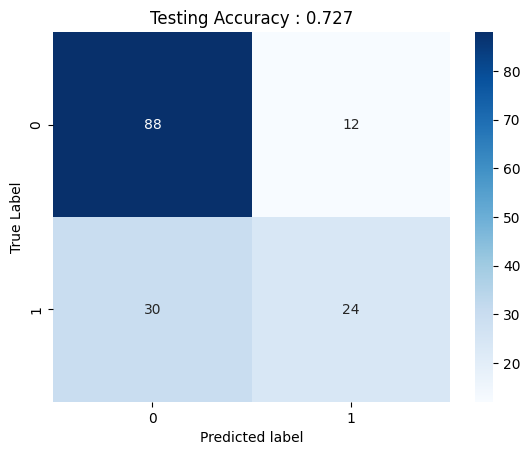

In [122]:
test_confusion_matrix = confusion_matrix(y_test, y_pred_class)
sns.heatmap(test_confusion_matrix, annot=True, fmt='.20g', cmap = plt.cm.Blues)
plt.xlabel("Predicted label")
plt.ylabel("True Label")
plt.title("Testing Accuracy : {:.3f}".format(accuracy))
plt.show()

In [103]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden1_dim, hidden2_dim):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(input_dim, hidden1_dim)
        self.hidden2 = nn.Linear(hidden1_dim, hidden2_dim)
        self.output = nn.Linear(hidden2_dim, 1) 
        self.activation = nn.ReLU()
#         self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.activation(self.hidden1(x))
        x = self.activation(self.hidden2(x))
        return self.activation(self.output(x))

In [104]:
clf = MLP(X.shape[1],128,256)
criterion = nn.BCELoss()
torch.manual_seed(3)

optimizer = optim.SGD(clf.parameters(), lr=0.01)
loss_history = []
num_epochs = 500
for epoch in range(num_epochs):
    clf.train()
    optimizer.zero_grad()
    outputs = clf(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss_history.append(loss.item())
    loss.backward()
    optimizer.step()

In [105]:
clf.eval()
with torch.no_grad():
    y_pred = clf(X_test_tensor)
    y_pred_class = (y_pred > 0.5).float()
    accuracy = (y_pred_class == y_test_tensor).float().mean()
    print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7468


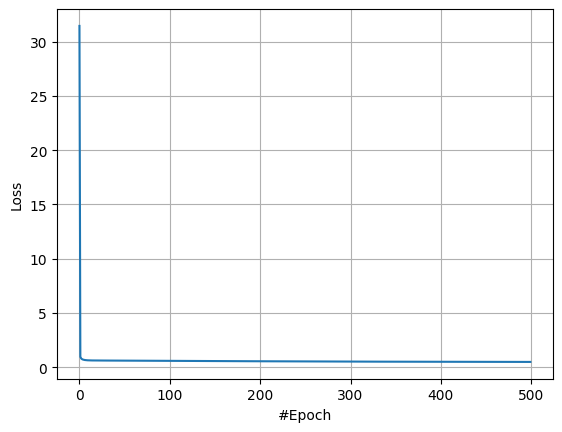

In [106]:
plt.plot(loss_history)
plt.xlabel("#Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

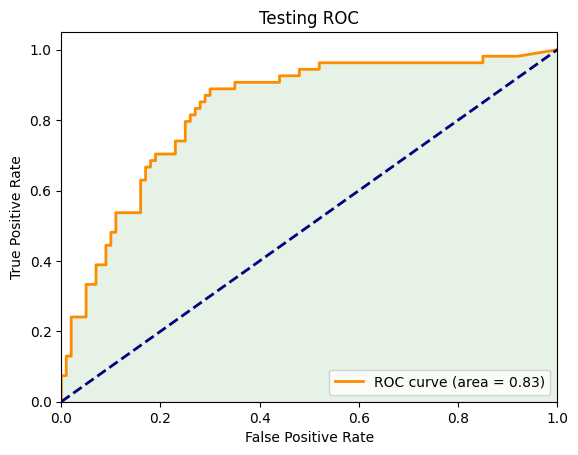

In [107]:
fpr,tpr,threshold = roc_curve(y_test, y_pred)
test_auc = auc(fpr,tpr)

plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % test_auc) 
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.fill_between(fpr, tpr, where=(tpr>0), color='green', alpha=0.1)
plt.title('Testing ROC')
plt.legend(loc="lower right")

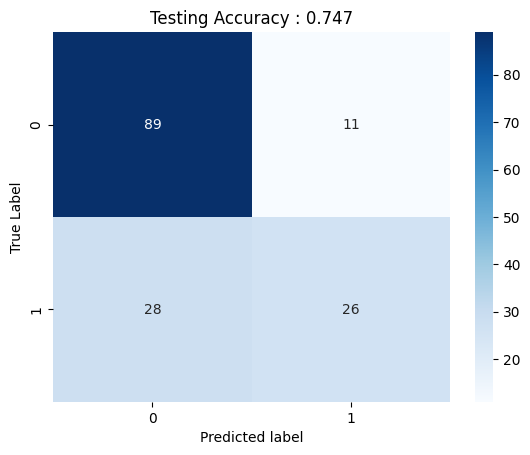

In [108]:
test_confusion_matrix = confusion_matrix(y_test, y_pred_class)
sns.heatmap(test_confusion_matrix, annot=True, fmt='.20g', cmap = plt.cm.Blues)
plt.xlabel("Predicted label")
plt.ylabel("True Label")
plt.title("Testing Accuracy : {:.3f}".format(accuracy))
plt.show()